# Doc2Vec

From example --


In [1]:
import gensim
import os
import collections
import smart_open
import random

In [2]:
# Set file names for train and test data
test_data_dir = '{}'.format(os.sep).join([gensim.__path__[0], 'test', 'test_data'])
lee_train_file = test_data_dir + os.sep + 'lee_background.cor'
lee_test_file = test_data_dir + os.sep + 'lee.cor'

In [3]:
def read_corpus(fname, tokens_only=False):
    with smart_open.smart_open(fname, encoding="iso-8859-1") as f:
        print(f)
        for i, line in enumerate(f):
            print(gensim.utils.simple_preprocess(line))
            if tokens_only:
                yield gensim.utils.simple_preprocess(line)
            else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(line), [i])

## Preprocesss

In [6]:
import re, string, unicodedata
import nltk
import contractions
import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

import numpy as np

In [7]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    text = re.sub('_',' ',text)
    return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

In [8]:
from sklearn.datasets import fetch_20newsgroups

In [9]:
corpus = fetch_20newsgroups(subset='all',remove=('headers', 'footers', 'quotes'))

In [10]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

In [11]:
def remove_emails(text):
    return re.sub('\S*@\S*\s?', '', text)

In [12]:
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

In [13]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

# def replace_numbers(words):
#     """Replace all interger occurrences in list of tokenized words with textual representation"""
#     p = inflect.engine()
#     new_words = []
#     for word in words:
#         if word.isdigit():
#             new_word = p.number_to_words(word)
#             new_words.append(new_word)
#         else:
#             new_words.append(word)
#     return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    #words = replace_numbers(words)
    words = remove_stopwords(words)
    words = [word for word in words if len(word)>2]
    return words

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/megan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
def preprocessor(doc):
    return normalize(nltk.word_tokenize(remove_numbers(remove_emails(replace_contractions(denoise_text(doc))))))

In [16]:
corpus.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

# Initialize the Doc2Vec Model

-Start by creating dictionary of tagged documents using the BOW vocabulary

In [125]:
import pickle

filename = 'BoW_normal2.sav'
BoW_vocab = pickle.load(open(filename, 'rb'))

/home/megan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.20.2 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [94]:
nontagged_documents = []
for i in corpus.data:
    nontagged_documents.append(preprocessor(i))

/home/megan/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


KeyboardInterrupt: 

In [155]:
nontagged_documents = []
for i in corpus.data:
    nontagged_documents.append([k for k in preprocessor(corpus.data[i]) if k in BoW_vocab.get_feature_names()], [i])

TypeError: list indices must be integers or slices, not str

In [154]:
tagged_documents = []
for i in range(len(corpus.data)):
    tagged_documents.append(gensim.models.doc2vec.TaggedDocument([k for k in preprocessor(corpus.data[i]) if k in BoW_vocab.get_feature_names()], [i]))

/home/megan/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [209]:
len(tagged_documents)

18846

In [79]:
#tagged_documents = []
#for i in range(len(corpus.data)):
#    tagged_documents.append(gensim.models.doc2vec.TaggedDocument(preprocessor(corpus.data[i]), [i]))

/home/megan/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [164]:
tagged_documents[3]

TaggedDocument(words=['think', 'scsi', 'card', 'dma', 'transfers', 'disks', 'scsi', 'card', 'dma', 'transfers', 'containing', 'data', 'scsi', 'devices', 'attached', 'wants', 'important', 'feature', 'scsi', 'ability', 'device', 'scsi', 'bus', 'devices', 'typically', 'used', 'multitasking', 'start', 'transfers', 'several', 'devices', 'device', 'seeking', 'data', 'bus', 'free', 'commands', 'data', 'transfers', 'devices', 'ready', 'transfer', 'data', 'bus', 'send', 'data', 'ide', 'bus', 'start', 'transfer', 'bus', 'busy', 'disk', 'data', 'typically', 'second', 'lock', 'processes', 'wanting', 'bus', 'irrespective', 'transfer', 'time'], tags=[3])

In [158]:
#tagged_documents[0][0]

In [159]:
#initialize gensim doc2vec model

model = gensim.models.doc2vec.Doc2Vec(vector_size=50, epochs=40)

In [151]:
def trim_rule(word,count,min_count,BoW_vocab):
    for word in tagged_documents:
        if word in BoW_vocab.get_feature_names():    
        # if word is equal to word in BoW 
            return gensim.utils.RULE_KEEP
        else: 
            return gensim.utils.RULE_DISCARD

In [ ]:
#model.build_vocab(tagged_documents, trim_rule=trim_rule(BoW_vocab.get_feature_names,100,1,BoW_vocab))

In [197]:
BoW_vocab.get_feature_names

<bound method CountVectorizer.get_feature_names of CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.2, max_features=None, min_df=5,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function preprocessor at 0x7f0773306bf8>,
        vocabulary=None)>

In [160]:
# build vocabulary off of tagged_documents

model.build_vocab(tagged_documents)

In [106]:
vocab = model.wv.vocab
print(vocab)

{'sure': <gensim.models.keyedvectors.Vocab object at 0x7f074ca06b70>, 'bashers': <gensim.models.keyedvectors.Vocab object at 0x7f07663ee400>, 'pens': <gensim.models.keyedvectors.Vocab object at 0x7f0765092278>, 'fans': <gensim.models.keyedvectors.Vocab object at 0x7f0765092a58>, 'pretty': <gensim.models.keyedvectors.Vocab object at 0x7f0765092048>, 'confused': <gensim.models.keyedvectors.Vocab object at 0x7f0765092470>, 'lack': <gensim.models.keyedvectors.Vocab object at 0x7f0765092b70>, 'kind': <gensim.models.keyedvectors.Vocab object at 0x7f0765092c50>, 'posts': <gensim.models.keyedvectors.Vocab object at 0x7f0771f9f668>, 'recent': <gensim.models.keyedvectors.Vocab object at 0x7f0771f9f470>, 'massacre': <gensim.models.keyedvectors.Vocab object at 0x7f0771f9f7b8>, 'devils': <gensim.models.keyedvectors.Vocab object at 0x7f0755d74be0>, 'actually': <gensim.models.keyedvectors.Vocab object at 0x7f0755d74e80>, 'bit': <gensim.models.keyedvectors.Vocab object at 0x7f0755d74400>, 'puzzled': <

In [107]:
model.corpus_count

18467

In [65]:
print(vector)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function preprocessor at 0x7f0773306bf8>,
        vocabulary=None)


In [161]:
# running Doc2Vec model on tagged documents vocab 

%time model.train(tagged_documents, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 3min 35s, sys: 3.41 s, total: 3min 39s
Wall time: 1min 42s


In [162]:
ranks = []
second_ranks = []
inferred_vector = []
for doc_id in range(len(tagged_documents)):
    inferred_vector.append(model.infer_vector(tagged_documents[doc_id].words))
    #sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    #rank = [docid for docid, sim in sims].index(doc_id)
    #ranks.append(rank)
    
    #second_ranks.append(sims[1])
    #inferred_vector.append(inferred_vector[i])

In [165]:
print(inferred_vector[1])
print(len(inferred_vector))

[-0.34756804 -0.23152786 -0.09310011  1.3488196   0.14026408  0.9362714
 -0.10659903  0.1653406   0.558226    0.8833102  -0.18872057  0.11876966
  0.15815558 -0.08979629 -0.6138517   1.2944574   0.66082263  0.32067037
 -1.3171781  -0.01520335  0.3452839  -0.14806809  0.4806254   0.5627182
 -0.42442393  0.96223104  0.30349782  0.19925605  0.6423783  -0.25160545
  0.03447515 -0.09334929  0.11051926 -0.3332661  -0.9354124  -0.19409955
 -1.1636877   0.54478353 -0.56936616 -0.8850801   0.05171627 -0.06241811
 -0.21342267  0.7537538  -0.8493273  -0.7139453  -0.5108081   0.01837328
 -0.4157641   0.18797134]
18846


In [28]:
sims = model.docvecs.most_similar(99)
print(sims)

[(6323, 0.7428580522537231), (5108, 0.7329476475715637), (11651, 0.7146692276000977), (8103, 0.714108943939209), (5850, 0.7130008935928345), (12659, 0.7093607187271118), (16565, 0.7090041041374207), (2774, 0.7042805552482605), (3873, 0.6947717070579529), (13802, 0.6906648874282837)]


In [58]:
tagged_documents[3]

TaggedDocument(words=['think', 'scsi', 'card', 'dma', 'transfers', 'disks', 'scsi', 'card', 'dma', 'transfers', 'containing', 'data', 'scsi', 'devices', 'attached', 'wants', 'important', 'feature', 'scsi', 'ability', 'detach', 'device', 'frees', 'scsi', 'bus', 'devices', 'typically', 'used', 'multitasking', 'start', 'transfers', 'several', 'devices', 'device', 'seeking', 'data', 'bus', 'free', 'commands', 'data', 'transfers', 'devices', 'ready', 'transfer', 'data', 'aquire', 'bus', 'send', 'data', 'ide', 'bus', 'start', 'transfer', 'bus', 'busy', 'disk', 'seeked', 'data', 'transfered', 'typically', 'second', 'lock', 'processes', 'wanting', 'bus', 'irrespective', 'transfer', 'time'], tags=[3])

In [26]:
collections.Counter(ranks)  # Results vary between runs due to random seeding and very small corpusn

Counter({0: 18076,
         6628: 1,
         6871: 1,
         15926: 1,
         10341: 1,
         9325: 1,
         1: 128,
         2447: 1,
         6981: 1,
         17926: 1,
         6941: 1,
         5117: 1,
         10090: 1,
         17323: 1,
         2377: 1,
         10533: 1,
         661: 1,
         13484: 1,
         7513: 1,
         9137: 1,
         17593: 1,
         3119: 1,
         12486: 1,
         17450: 1,
         7447: 1,
         3522: 1,
         16403: 1,
         5507: 1,
         16167: 1,
         13118: 1,
         14: 2,
         14591: 1,
         2225: 1,
         3210: 1,
         14957: 1,
         2946: 1,
         935: 1,
         1623: 1,
         10994: 1,
         15566: 1,
         13170: 1,
         11317: 1,
         2903: 1,
         4240: 1,
         10110: 1,
         18703: 1,
         11012: 1,
         5: 3,
         8255: 1,
         6965: 1,
         14614: 1,
         13075: 1,
         3487: 1,
         6974: 1,
         18

In [56]:
print(second_ranks)
print(len(second_ranks))

[(931, 0.6459512114524841), (4882, 0.825847327709198), (5478, 0.7548763155937195), (18421, 0.7021302580833435), (3071, 0.660570502281189), (13105, 0.6747095584869385), (6845, 0.7697665691375732), (18794, 0.664376974105835), (16273, 0.7312692999839783), (3556, 0.7838566899299622), (7241, 0.6844649314880371), (4234, 0.9473956227302551), (2626, 0.6979853510856628), (13986, 0.6227126121520996), (1318, 0.781317949295044), (8931, 0.6516743898391724), (15100, 0.663560152053833), (4058, 0.6204073429107666), (5524, 0.7285040616989136), (9915, 0.7291627526283264), (11350, 0.6714484691619873), (17676, 0.633254885673523), (17341, 0.5628423094749451), (10815, 0.7460896968841553), (12084, 0.7197643518447876), (14511, 0.7756205201148987), (3334, 0.6345208883285522), (18720, 0.7419975996017456), (16800, 0.683506190776825), (5279, 0.7129411697387695), (8793, 0.6279478669166565), (13353, 0.6599441766738892), (8286, 0.7783270478248596), (7208, 0.7073906660079956), (11782, 0.757803201675415), (15394, 0.67

In [45]:
# Pick a random document from the corpus and infer a vector from the model
doc_id = random.randint(0, len(tagged_documents) - 1)

# Compare and print the second-most-similar document
print('Train Document ({}): «{}»\n'.format(doc_id, ' '.join(tagged_documents[doc_id].words)))
sim_id = second_ranks[doc_id]
print('Similar Document {}: «{}»\n'.format(sim_id, ' '.join(tagged_documents[sim_id[0]].words)))

Train Document (17759): «traction control far optional feature one buys cars thing torque sensing differential torque sensing differential type lsd lsds torque sensing viscous coupled differentials opposed viscous couplings rotational sensing torque sensing matter traction control systems use abs sensors pulse braking older positracs whatever familiar workings»

Similar Document (16524, 0.7491637468338013): «since subject brakes anyone know vauxhall opel disengages drive rear wheels brakes applied vauxhall boast car stable fwd mode braking mode shaz»



In [112]:
inferred_vector = []
for i in range(len(nontagged_documents)):
    inferred_vector.append(model.infer_vector(tagged_documents[doc_id]))
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

TypeError: sequence item 0: expected str instance, list found

# Doc2Vec on Tf-IDF model

Load TF-idf 


In [191]:
import pickle

filename = 'tf_idf_normal2.sav'
tfidf_vocab = pickle.load(open(filename, 'rb'))

/home/megan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.20.2 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/megan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.20.2 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [193]:
tfidf_vocab.get_feature_names

<bound method CountVectorizer.get_feature_names of TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.2, max_features=None, min_df=5,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function preprocessor at 0x7f0773306bf8>, use_idf=True,
        vocabulary=None)>

In [198]:
tagged_documents_tfidf = []
for i in range(len(corpus.data)):
    tagged_documents_tfidf.append(gensim.models.doc2vec.TaggedDocument([k for k in preprocessor(corpus.data[i]) if k in tfidf_vocab.get_feature_names()], [i]))

KeyboardInterrupt: 

In [199]:
len(tagged_documents_tfidf)

2242

In [201]:
model2 = gensim.models.doc2vec.Doc2Vec(vector_size=50, epochs=40)

In [202]:
model2.build_vocab(tagged_documents_tfidf)

In [203]:
%time model2.train(tagged_documents_tfidf, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 38.8 s, sys: 1.1 s, total: 39.9 s
Wall time: 19.6 s


In [205]:
inferred_vector_tfidf = []
for doc_id in range(len(tagged_documents_tfidf)):
    inferred_vector_tfidf.append(model.infer_vector(tagged_documents_tfidf[doc_id].words))

(2242, 2)

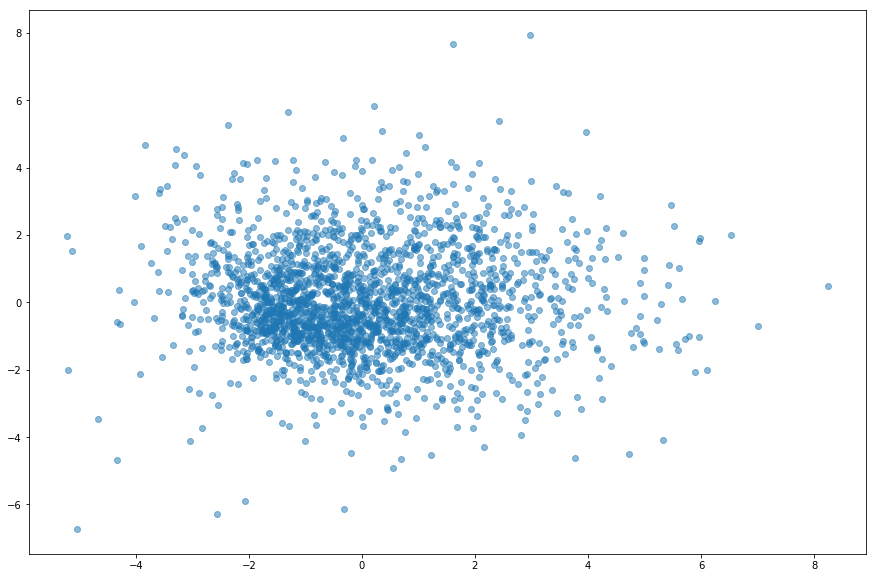

In [207]:
X1 = inferred_vector_tfidf
pca = PCA(n_components=2, svd_solver='full')
pca.fit(X1)
new_data1 = pca.transform(X1)
plt.figure(figsize=(15,10))
plt.scatter(new_data1[:,0],new_data1[:, 1],alpha=.5)
new_data1.shape

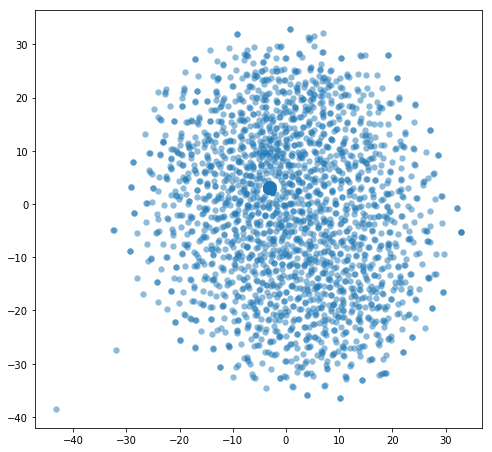

In [208]:
tsne_data = TSNE().fit_transform(X1)

# We choose a color palette with seaborn.
palette = np.array(sns.color_palette("hls", 10))
# We create a scatter plot.
f = plt.figure(figsize=(8, 8))
ax = plt.subplot(aspect='equal')
sc = ax.scatter(tsne_data[:,0], tsne_data[:,1], lw=0, s=40,alpha=0.5)

# Visualizations

- t-SNE
- PCA 


https://www.kaggle.com/arthurtok/target-visualization-t-sne-and-doc2vec
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
https://github.com/BoPengGit/LDA-Doc2Vec-example-with-PCA-LDAvis-visualization/blob/master/Doc2Vec/Doc2Vec2.ipynb
https://github.com/BoPengGit/LDA-Doc2Vec-example-with-PCA-LDAvis-visualization/blob/master/PCA/PCA.ipynb
https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
https://github.com/mGalarnyk/Python_Tutorials/blob/master/Sklearn/PCA/PCA_Data_Visualization_Iris_Dataset_Blog.ipynb

In [171]:
import matplotlib.pyplot as plt

In [172]:
#PCA Visualization
#create vector of data
#visualize the data
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#need to create matrix of data 
X = inferred_vector
pca = PCA(n_components=2, svd_solver='full')
pca.fit(X)
new_data = pca.transform(X)

(18846, 2)

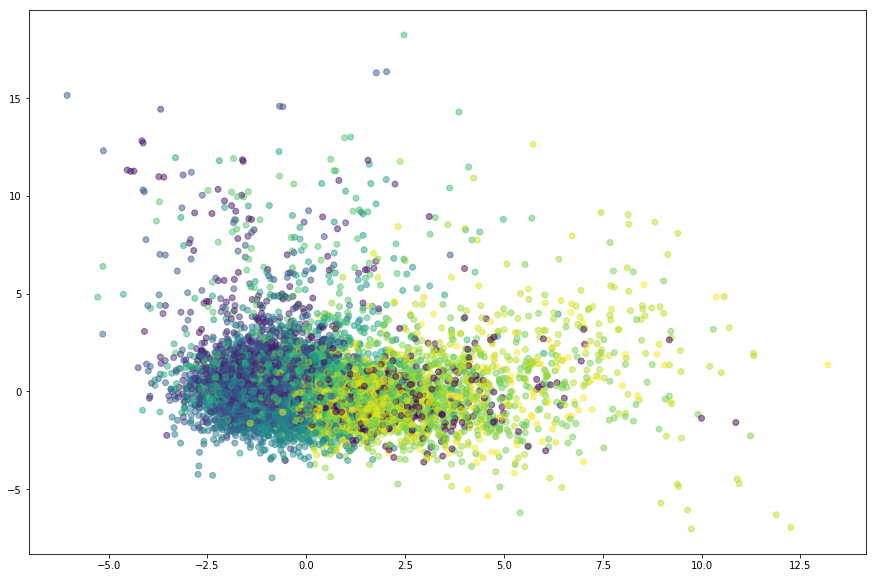

In [183]:
plt.figure(figsize=(15,10))
plt.scatter(new_data[:,0],new_data[:, 1], c=corpus.target,alpha=.5)
new_data.shape

In [184]:
#tsne_model = TSNE(n_jobs=4,early_exaggeration=4,n_components=2,verbose=1,random_state=2018,n_iter=300)
#tsne_d2v = tsne_model.fit_transform(model.docvecs.vectors_docs)

tsne_data = TSNE().fit_transform(X)

# Putting the tsne information into sq
#tsne_d2v_df = pd.DataFrame(data=tsne_d2v, columns=["x", "y"])
# tsne_tfidf_df.columns = ["x", "y"]
#tsne_d2v_df["qid"] = train_rebal["qid"].values
#tsne_d2v_df["question_text"] = train_rebal["question_text"].values
#tsne_d2v_df["target"] = train_rebal["target"].values

NameError: name 'pd' is not defined

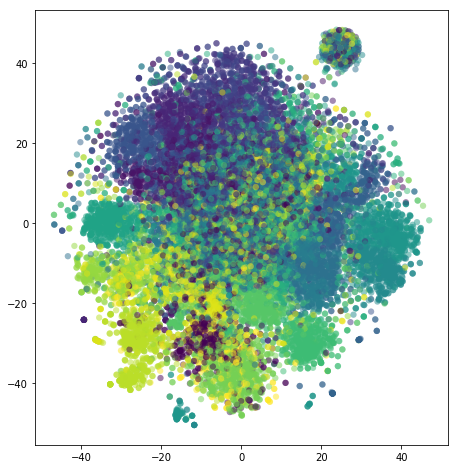

In [189]:
import seaborn as sns
# We choose a color palette with seaborn.
palette = np.array(sns.color_palette("hls", 10))

# We create a scatter plot.
f = plt.figure(figsize=(8, 8))
ax = plt.subplot(aspect='equal')
sc = ax.scatter(tsne_data[:,0], tsne_data[:,1], lw=0, s=40,c=corpus.target,alpha=0.5)

In [190]:
corpus.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']